In [14]:
import numpy as np
from skimage.morphology import skeletonize, medial_axis, watershed, disk
from skimage.feature import canny
from scipy import ndimage as ndi
from scipy.spatial import distance
#import matplotlib.pyplot as plt
from skimage.util import invert
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage.feature import peak_local_max, canny
from scipy import ndimage
from skimage.filters import sobel, gaussian 
from skimage.measure import label, regionprops
from skimage.filters import rank

%matplotlib inline
import numpy as np
from skimage.feature import canny
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.morphology import watershed, disk
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage import segmentation 
np.set_printoptions(threshold = np.nan)
import math
from skimage import morphology 
from skimage.measure import label, regionprops
from skimage.feature import corner_harris, corner_subpix, corner_peaks



/home/jon-ross/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/jon-ross/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


Preprocessed Image


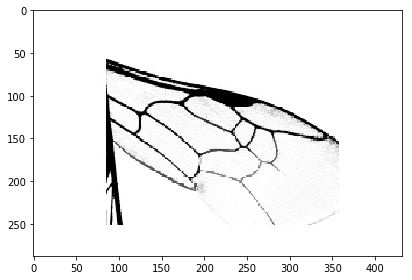

In [15]:
img = imread("enhanced_image/1 Lasioglossum leucozonium f left 3.2x.jpg")[:,:,0]
denoised = rank.median(img, disk(2))
markers = rank.gradient(denoised, disk(5)) < 10
markers = ndi.label(markers)[0]
gradient = rank.gradient(denoised, disk(2))
labels = watershed(gradient, markers)
cleared = segmentation.clear_border(labels)
imshow(img)
print("Preprocessed Image")

/home/jon-ross/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/jon-ross/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


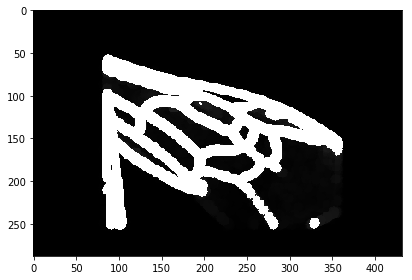

In [16]:
denoised = rank.median(img, disk(2))
gradient = rank.gradient(denoised, disk(5))
thres = 30
gradient[gradient > thres] = 255

imshow(gradient)

Number of Regions:  26
Filtered Regions:  10


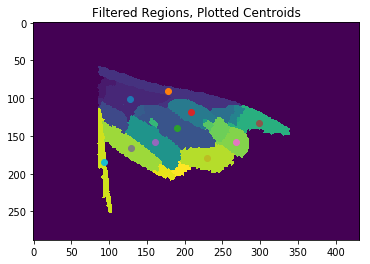

In [17]:
labeled_wing = cleared
regions = regionprops(labeled_wing)
print("Number of Regions: ", len(regions))
implot = plt.imshow(cleared)

#filters regions based on area
filtered_regions = []
filtered_regions_area = []
for props in regions:
    area = props.area
    if area > 1000 and area < 400000:
        filtered_regions.append(props)
        filtered_regions_area.append(area)
print("Filtered Regions: ", len(filtered_regions))

for region in filtered_regions:
    y0, x0 = region.centroid
    plt.scatter([x0], [y0])
plt.title("Filtered Regions, Plotted Centroids")
plt.show()

Center of Regions: 


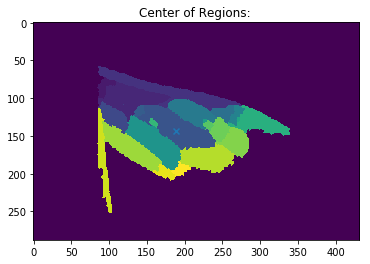

In [18]:
#Finds the centroid of all the region centers

centroids = []
centroids_x = []
centroids_y = []
for region in filtered_regions:
    y0, x0 = region.centroid
    region_centroid = (x0, y0)
    centroids.append(region_centroid)
    centroids_x.append(x0)
    centroids_y.append(y0)
    
avg_x = np.mean(centroids_x)
avg_y = np.mean(centroids_y)

print("Center of Regions: ")
implot = plt.imshow(labeled_wing)
plt.scatter([avg_x], [avg_y], marker = "x")
plt.title("Center of Regions: ")
plt.show()

In [19]:
#Calculates the distance between each centroid to the center

distances_from_center = []
for centroid in centroids:
    distances_from_center.append(distance.euclidean(centroid, (avg_x, avg_y)))

distance_sd = np.std(distances_from_center)
distance_mean = np.mean(distances_from_center)
                                 
dist_from_cent_norm = [dist_from_center / distance_mean for dist_from_center in distances_from_center]
print("Distance, Scaled: \n", dist_from_cent_norm)
                                 
area_sd = np.std(filtered_regions_area)
area_mean = np.mean(filtered_regions_area)
area_norm = [area / area_mean for area in filtered_regions_area]
print("Area, Scaled: \n", area_norm)

Distance, Scaled: 
 [1.2080318996645132, 0.8752214101092546, 0.05762511326168648, 0.520264594696888, 0.5266016920604524, 1.8120307451785531, 1.3283859958769786, 1.0521305017384384, 0.9105296421972809, 1.7091784052159547]
Area, Scaled: 
 [1.1617444691436434, 1.3575738329628453, 1.5327617232984014, 0.7235101090293214, 1.2210225468402667, 0.8066052715147666, 0.5398539218799618, 1.0675346670900814, 1.0130200063512225, 0.5763734518894887]


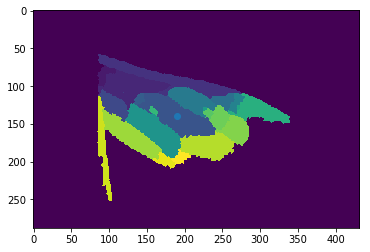

In [20]:
#Weights each region centroid based on distance to the center
implot = plt.imshow(labeled_wing)
distance_weight = 1
size_weight = 1

weighted_values = []
for i in range(len(filtered_regions)):
    weighted_values.append(size_weight * area_norm[i] - distance_weight * dist_from_cent_norm[i])

max_index = weighted_values.index(max(weighted_values))
center_cell = filtered_regions[max_index]
center_cell_x, center_cell_y = center_cell.centroid[1], center_cell.centroid[0]
plt.scatter([center_cell_x], [center_cell_y])

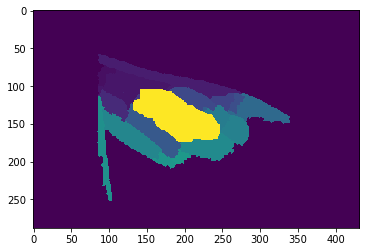

In [21]:
#print(center_cell.coords)
from copy import deepcopy

bloated_labeled_wing = deepcopy(labeled_wing)

for coord in center_cell.coords:
    for i in range(-5, 6):
        for j in range(-5, 6):
            bloated_labeled_wing[coord[0] + j][coord[1] + i] = 50
plt.imshow(bloated_labeled_wing)

In [22]:
surrounding_regions = set()
for coord in center_cell.coords:
    for i in range(-10, 11):
        for j in range(-10, 11):
            surrounding_regions.add((coord[0] + i, coord[1] + j))

surrounding_regions_x = [element[0] for element in surrounding_regions]
surrounding_regions_y = [element[1] for element in surrounding_regions]
            
#plt.scatter()

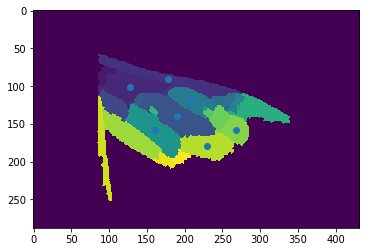

In [23]:
implot = plt.imshow(labeled_wing)


def is_neighbor(region):
    """Takes a region object as input"""
    region_tuple = [tuple(k) for k in region.coords]
    return any([coord in surrounding_regions for coord in region_tuple])

"""
for i in range(len(properties)):
    region_tuple = [tuple(k) for k in properties[1].coords]
    print(region_tuple)
    #print([(coord in surrounding_regions) for coord in region_tuple])
"""

neighbor_x = []
neighbor_y = []
for region in filtered_regions:
    if is_neighbor(region):
        neighbor_y.append(region.centroid[0])
        neighbor_x.append(region.centroid[1])
plt.scatter(neighbor_x, neighbor_y)

In [24]:
neighbors = []

for region in filtered_regions:
    if is_neighbor(region):
        neighbors.append(region)
        
for region in neighbors:
    if region is center_cell:
        neighbors.remove(region)

#Feature vector about the star cell
star_features = [center_cell.area, center_cell.eccentricity]

#Feature vector about the adjacent cells
adjacent_features = [len(neighbors), np.mean([region.area for region in neighbors]), np.std([region.area for region in neighbors])]

star_features + adjacent_features

[2896, 0.9419840709457189, 6, 1894.6666666666667, 540.588157061876]